In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import pmdarima as pm
import yfinance as yf

In [2]:
today = datetime.today().strftime('%Y-%m-%d')
start_date = '2016-01-01'
eth_df = yf.download('ETH-USD', start_date, today)
eth_df.reset_index(inplace=True)

#taking opening price as the column of interest
df = eth_df[["Date", "Open"]]
new_names = {
    "Open": "Value",
}

df.rename(columns=new_names, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])


train_set = df.iloc[:(len(df)-7), :] #df.loc[df['Date'] < '2022-05-01']
test_set = df.iloc[(len(df)-7):len(df), :] #df.loc[df.Date >= '2022-05-01']

#train_set copy 
train_set_orig = train_set.copy()

[*********************100%***********************]  1 of 1 completed


In [3]:
#Verify train and test sets are correctly split
test_set

,Date,Value
1669,2022-06-05,1801.818970
1670,2022-06-06,1805.635986
1671,2022-06-07,1859.333740
1672,2022-06-08,1814.100708
1673,2022-06-09,1793.512817
1674,2022-06-10,1789.689941
1675,2022-06-11,1665.217896


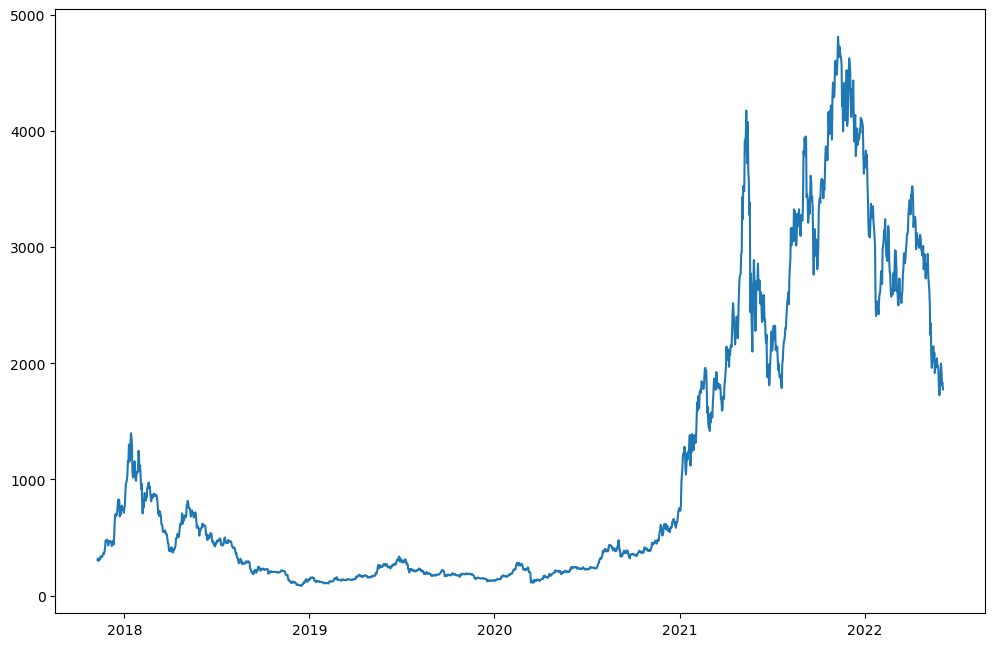

In [4]:
#Plotting Price values
fig, ax = plt.subplots(figsize=(12,8), dpi = 100)
ax.plot(train_set['Date'], train_set['Value'])

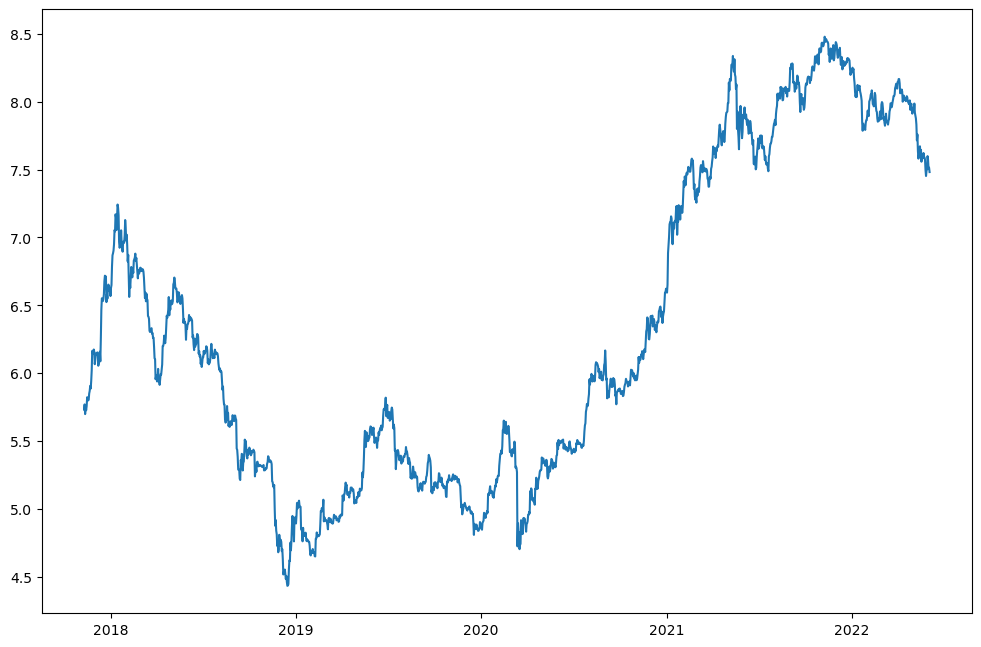

In [5]:
#Plotting log values of the Price
train_set['Value'] = np.log(train_set['Value'])
fig, ax = plt.subplots(figsize=(12,8), dpi = 100)
ax.plot(train_set['Date'], train_set['Value'])

In [6]:
#Augmented Dicky Fuller Test (ADF Test) for checking the series is stationary or not
def adf_test(target_series):
    result = adfuller(target_series)
    adf_statistic = result[0]
    p_value = result[1] 
    print('ADF Statistic : % f' % adf_statistic )
    print ('p - value : % f' % p_value ) 
    return adf_statistic  , p_value 

adf_statistic, p_value = adf_test(train_set['Value']) #ADF p value is greater than 0.5, so series is non stationary 

ADF Statistic : -0.826101
p - value :  0.811335


In [7]:
#The Kwiatkowski–Phillips–Schmidt–Shin (KPSS)
def kpss_test(target_series ) :
    print("Results of KPSS Test : " ) 
    kpsstest = kpss(target_series , regression = "ct" , nlags = "auto") 
    kpss_output = pd.Series( 
        kpsstest[ 0 : 3 ] , index = [" Test Statistic " , " p - value " , " Lags Used " ] )
    for key , value in kpsstest[ 3 ].items() : 
        kpss_output[" Critical Value ( %s )" % key ] = value
    print( kpss_output )
    
kpss_test(train_set['Value']) # p value < 0.05, so series is non stationary 

Results of KPSS Test : 
 Test Statistic              1.267334
 p - value                   0.010000
 Lags Used                  26.000000
 Critical Value ( 10% )      0.119000
 Critical Value ( 5% )       0.146000
 Critical Value ( 2.5% )     0.176000
 Critical Value ( 1% )       0.216000
dtype: float64


In [8]:
#Differentiate the series till we get p value of ADF test less than 0.05
def best_diff_factor(p_value, df):
    d = 0
    while p_value > 0.05:
        df['Value'] = df['Value'].diff()
        df.dropna(inplace = True)
        d+=1 
        adf_statistic, p_value = adf_test(df['Value'])
    print("final d value = %f" % d)
    return df

train_set= best_diff_factor(p_value, train_set) 

ADF Statistic : -14.868194
p - value :  0.000000
final d value = 1.000000


In [9]:
kpss_test(train_set['Value']) #Check the KPSS test p value

Results of KPSS Test : 
 Test Statistic             0.141666
 p - value                  0.058025
 Lags Used                  8.000000
 Critical Value ( 10% )     0.119000
 Critical Value ( 5% )      0.146000
 Critical Value ( 2.5% )    0.176000
 Critical Value ( 1% )      0.216000
dtype: float64


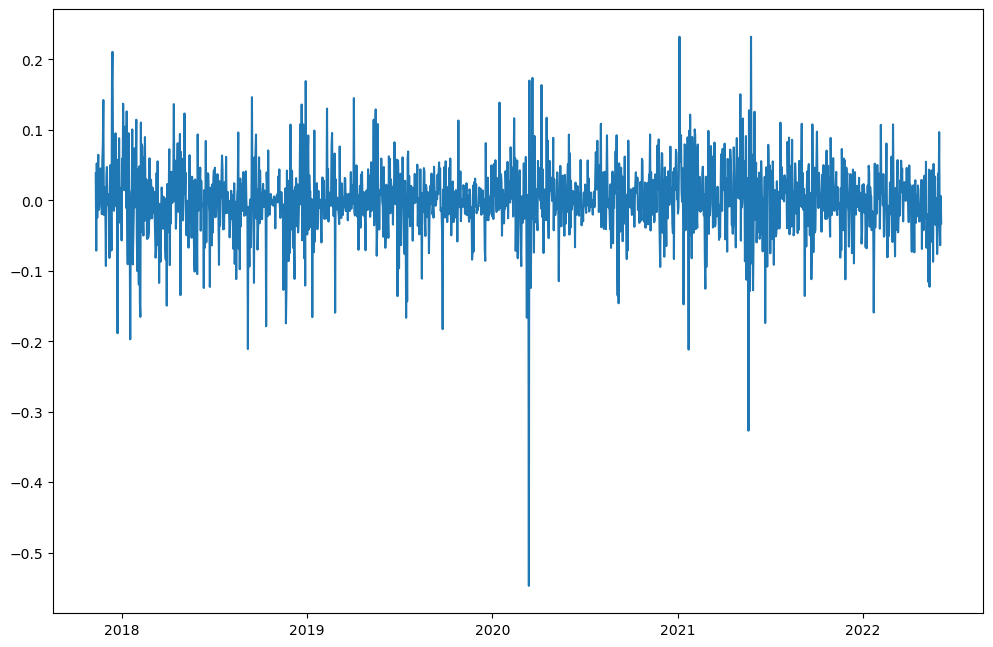

In [10]:
fig, ax = plt.subplots(figsize=(12,8), dpi = 100)
ax.plot(train_set['Date'], train_set['Value'])

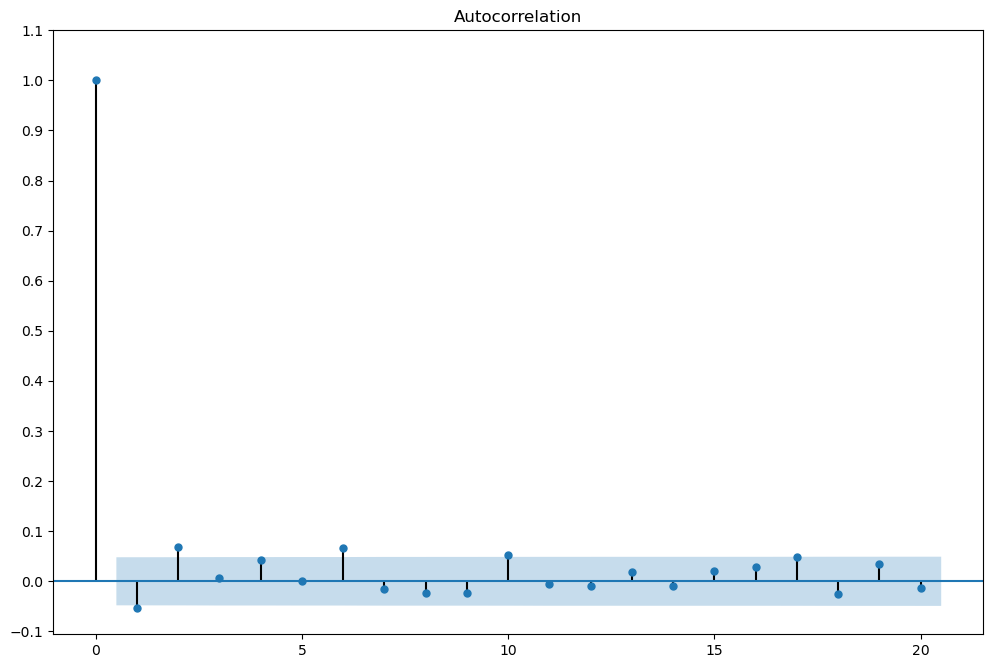

In [11]:
#ACF plot to check correlation coefficients between the price time series and its lag values
fig, ax = plt.subplots(figsize=(12,8), dpi = 100)
plot_acf(train_set['Value'], lags=20, ax=ax)
plt.ylim = ([-0.05, 0.25])
plt.yticks(np.arange(-0.10, 1.1, 0.1))
plt.show()

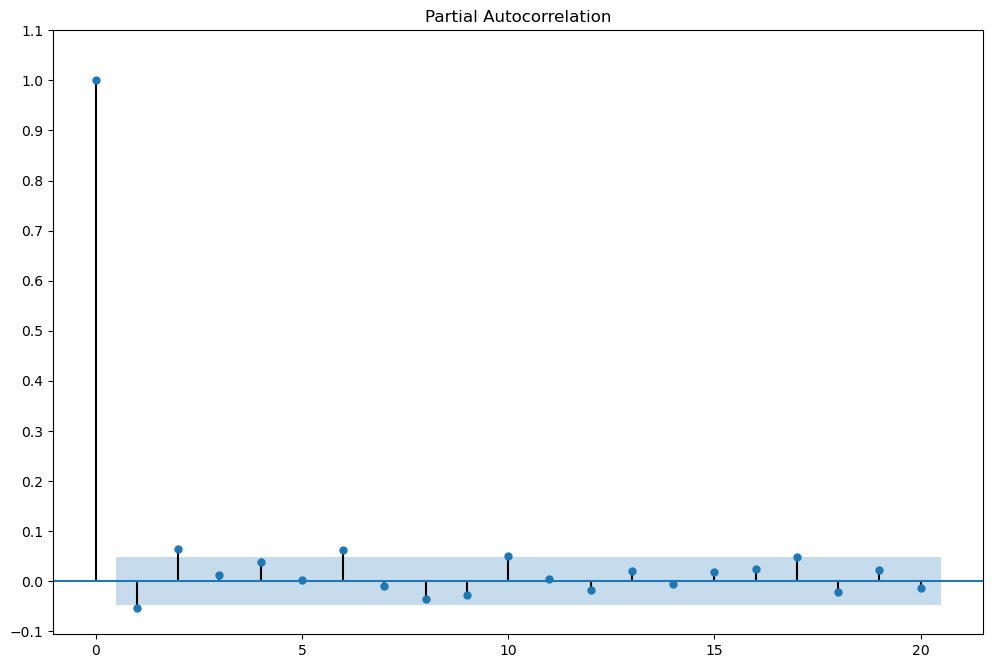

In [12]:
#PACF to get the partial correlation between the series and its lags
fig, ax = plt.subplots(figsize=(12,8), dpi = 100)
plot_pacf(train_set['Value'], lags=20, ax=ax)
plt.ylim = ([-0.05, 0.25])
plt.yticks(np.arange(-0.10, 1.1, 0.1))
plt.show()

In [13]:
#Using Ljung–Box test to determine whether any group of autocorrelations in a time series differs from zero.
#H0: The data is distributed independently.
#H1: The data is not distributed randomly; instead, they exhibit serial correlation.
sm.stats.acorr_ljungbox(train_set['Value'], lags= [20], return_df=True)

,lb_stat,lb_pvalue
20,40.115659,0.00483


In [14]:
#Now applying auto arima to find the p, d and q values
def auto_arima(orig_df) :
    orig_df = np.log(orig_df['Value'])
    model = pm.auto_arima(orig_df,
                          start_p = 10 ,
                          start_q = 10, 
                          test = 'adf',
                          max_p = 10 ,
                          max_q = 10 ,
                          m = 1 ,
                          d = None ,
                          seasonal = False ,
                          D = 0 , 
                          trace = True ,
                          error_action = 'ignore', 
                          suppress_warnings = True , 
                          stepwise = True ) 
    # difference df by d found by auto arima 
    differenced_by_auto_arima = orig_df.diff(model.order[1]) 
    return model.order , differenced_by_auto_arima , model.resid( ) 

model_order , differenced_data , model_residuals = auto_arima(train_set_orig)

Performing stepwise search to minimize aic
 ARIMA(10,1,10)(0,0,0)[0] intercept   : AIC=-5129.116, Time=7.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5135.466, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5138.180, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5137.623, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5136.784, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5143.284, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-5141.539, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5141.866, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5143.133, Time=0.64 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5139.583, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5144.622, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5139.422, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-5142.894, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5144.918, Time=0.46 sec
 ARIMA(1,1,1)(0,0

In [15]:
#applying the Ljung–Box test again to the model’s residuals
sm.stats.acorr_ljungbox(model_residuals, lags= [20], return_df=True) #p_value 0.99 signifies residual are just white noise

,lb_stat,lb_pvalue
20,2.809764,0.999998


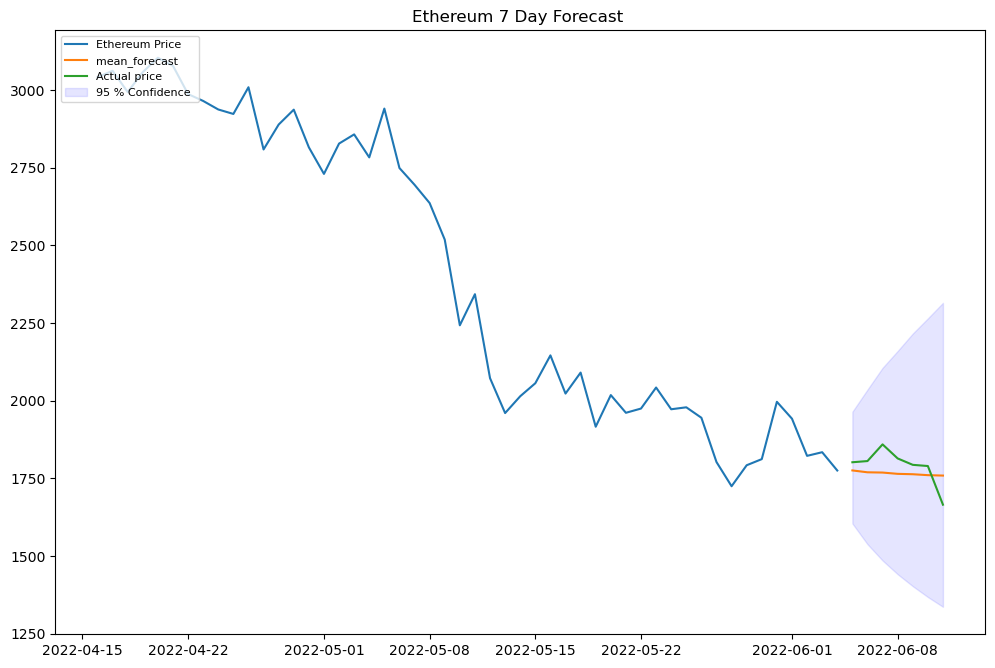

In [16]:
#fit the model with above returned parameters for best model
model = sm.tsa.arima.ARIMA(np.log(train_set_orig['Value']), order = (2,1,2))
fitted = model.fit()

#Create forecast for 7 days 
fc = fitted.get_forecast(7)

#Set confidence to 95 % 
fc = (fc.summary_frame(alpha = 0.05)) 

#Get mean forecast 
fc_mean = fc['mean'] 

#Get lower confidence forecast 
fc_lower = fc['mean_ci_lower'] 

#Get upper confidence forecast 
fc_upper = fc['mean_ci_upper']

# Set figure size 
plt.figure(figsize=( 12,8 ) , dpi = 100 ) 

#Plot last 100 price movements 
plt.plot(train_set_orig['Date'][-50:] , train_set_orig['Value'][-50:] , label = 'Ethereum Price ' ) 

#create date axis for predictions 
future_7_days = test_set['Date']

#Plot mean forecast 
plt.plot(future_7_days, np.exp(fc_mean) , label = 'mean_forecast', linewidth = 1.5 )

#Plot actual test values
plt.plot(future_7_days, test_set['Value'] , label = 'Actual price', linewidth = 1.5 )

#Create confidence interval 

plt.fill_between(future_7_days , np.exp(fc_lower) , np.exp(fc_upper) , color = 'b' 
                 , alpha = .1 , label = '95 % Confidence ' ) 

#Set title 
plt.title ('Ethereum 7 Day Forecast ' ) 

#Set legend 
plt.legend(loc = 'upper left' , fontsize = 8 ) 
plt.show ( )